In [4]:
from pathlib import Path
import random
import logging
import numpy as np
import torch
from torch.utils.data import Dataset
import sys
import matplotlib.pyplot as plt
import cv2
import math
try:
    import midaGAN
except ImportError:
    sys.path.append('../')
    import midaGAN
    

from midaGAN.utils.io import make_recursive_dataset_of_files, load_json
from midaGAN.utils import sitk_utils
from midaGAN.data.utils import volume_invalid_check_and_replace
from midaGAN.data.utils.normalization import min_max_normalize, min_max_denormalize
from midaGAN.data.utils.register_truncate import truncate_CT_to_scope_of_CBCT
from midaGAN.data.utils.fov_truncate import truncate_CBCT_based_on_fov
from midaGAN.data.utils.body_mask import body_mask_and_bound

from midaGAN.data.utils.stochastic_focal_patching import StochasticFocalPatchSampler

from viz import show_mid_slices
import SimpleITK as sitk

In [5]:
EXTENSIONS = ['.nrrd']

root_path = Path('/repos/Maastro/nki_cervix')

paths_CBCT = {}
paths_CT = {}

for patient in root_path.iterdir():
    paths_CBCT[patient.stem] = make_recursive_dataset_of_files(patient / "CBCT", EXTENSIONS)
    CT_nrrds = make_recursive_dataset_of_files(patient / "CT", EXTENSIONS)
    paths_CT[patient.stem] = [path for path in CT_nrrds if path.stem == "CT"]
    

In [6]:
patient_index = list(paths_CT)[2]

In [7]:
path_CBCT = paths_CBCT[patient_index][0]
path_CT = random.choice(paths_CT[patient_index])

In [8]:
# load nrrd as SimpleITK objects
CBCT = sitk_utils.load(path_CBCT)
CT = sitk_utils.load(path_CT)

In [ ]:
# # Subtract 1024 from CBCT to map values from grayscale to HU approx
# ONLY FOR NKI DATA
CBCT = CBCT - 1024

In [9]:
CBCT = truncate_CBCT_based_on_fov(CBCT)

In [10]:
CT_truncated = truncate_CT_to_scope_of_CBCT(CT, CBCT)

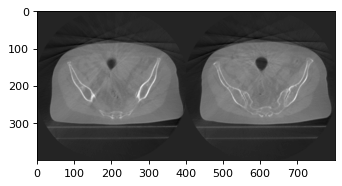

In [11]:
show_mid_slices(CBCT, show_axis=(False, False, True))

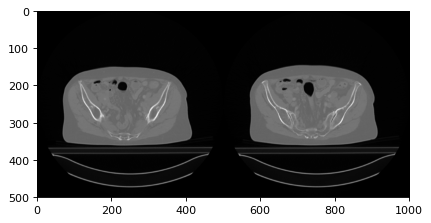

In [19]:
show_mid_slices(CT_truncated, show_axis=(False, False, True))

In [16]:
# Utility function to visualize the mask and bounds
def show_mask_bound(array, mask, bound):
    for n_slice in range(array.shape[0]):
        fig, axs = plt.subplots(1, 2)
        img = array[n_slice]
        cv2.rectangle(img, (bound[2][0], bound[1][0]), (bound[2][1], bound[1][1]), 3000, 2)
        axs[0].imshow(img, cmap='gray')    

        axs[1].imshow(mask[n_slice], cmap='gray')
        plt.show()

Number of connected components found: 601


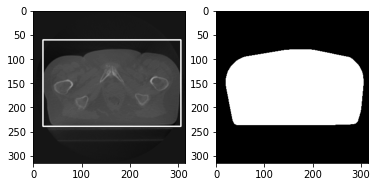

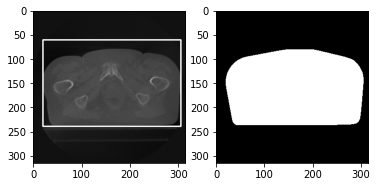

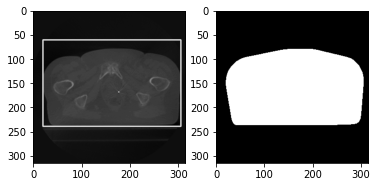

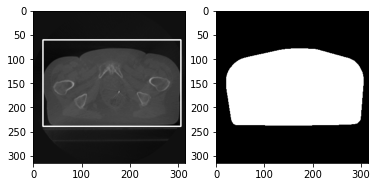

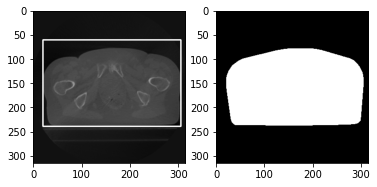

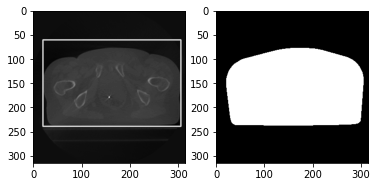

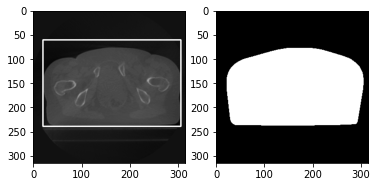

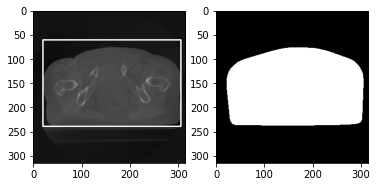

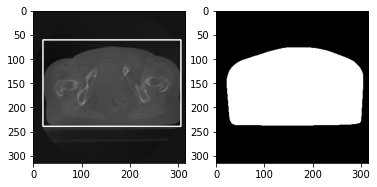

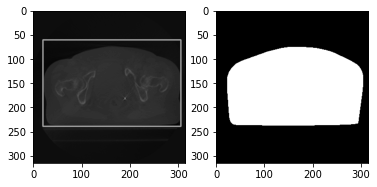

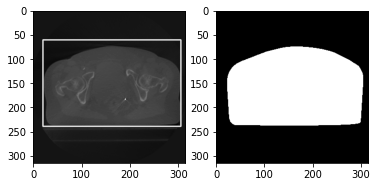

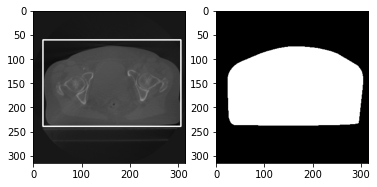

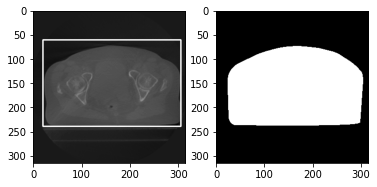

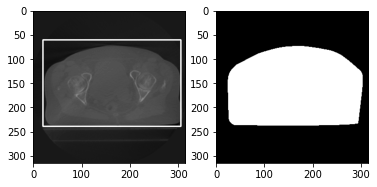

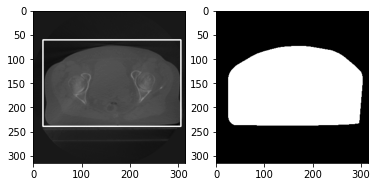

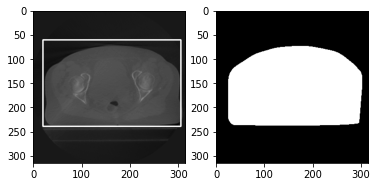

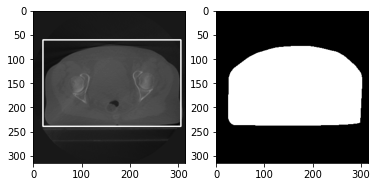

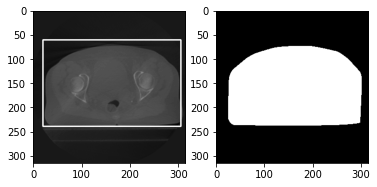

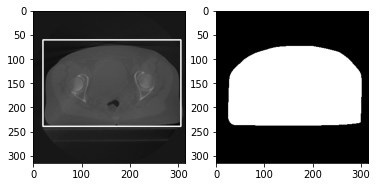

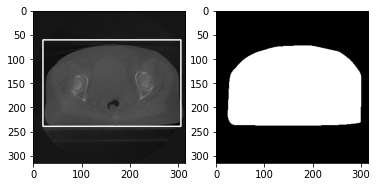

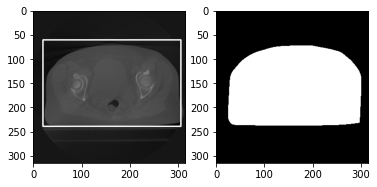

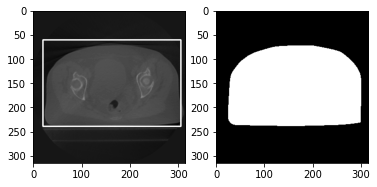

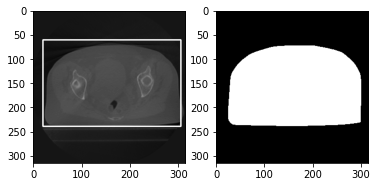

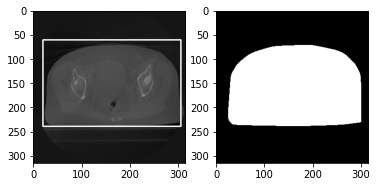

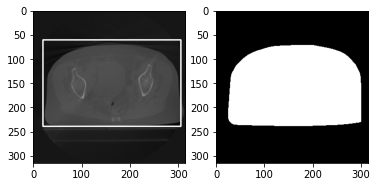

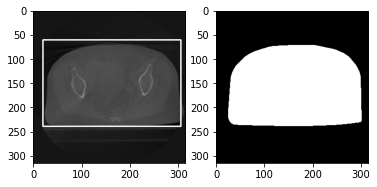

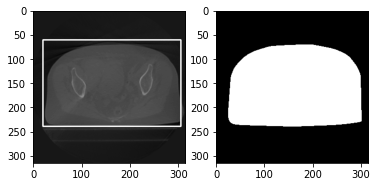

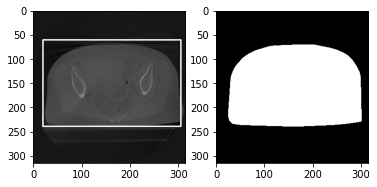

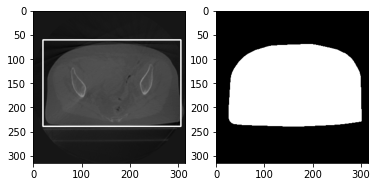

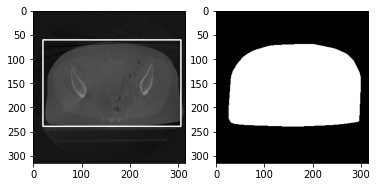

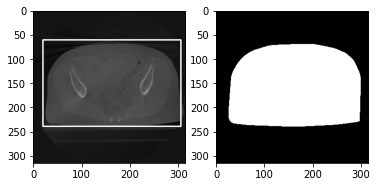

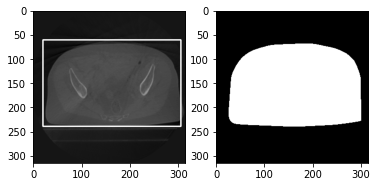

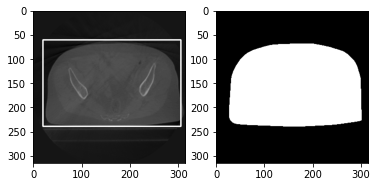

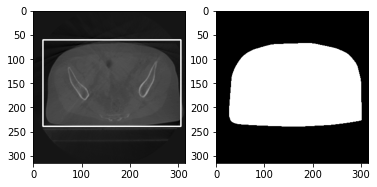

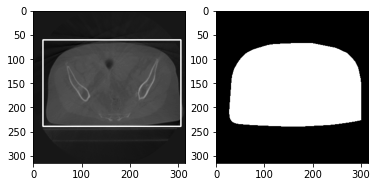

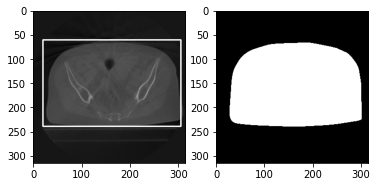

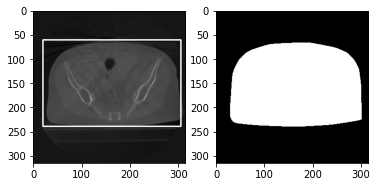

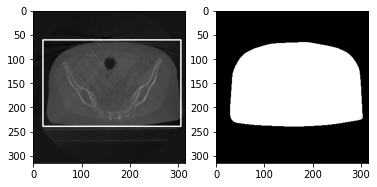

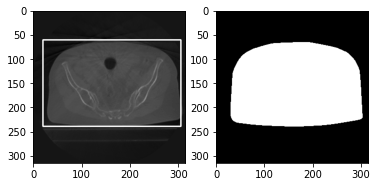

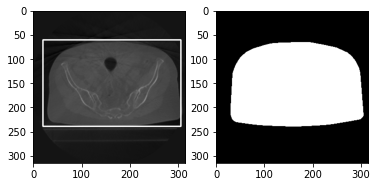

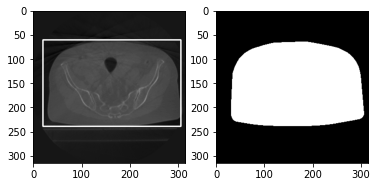

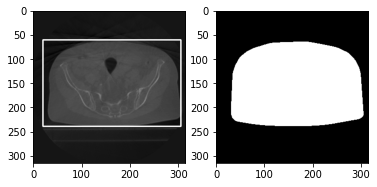

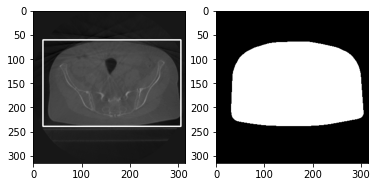

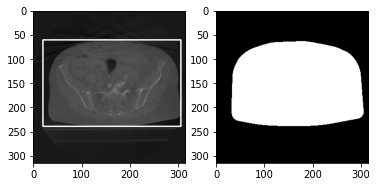

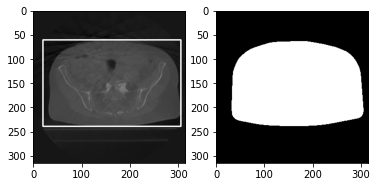

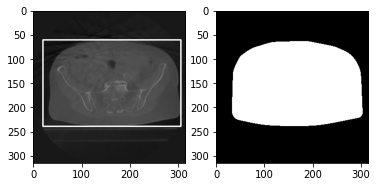

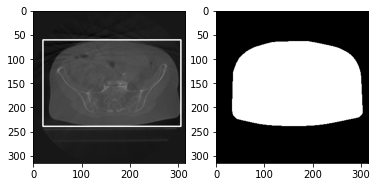

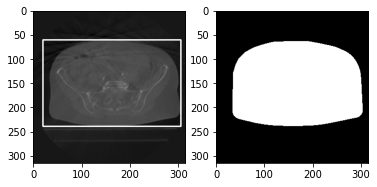

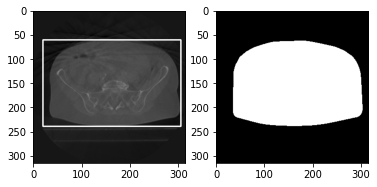

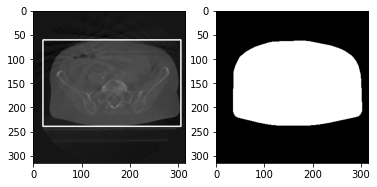

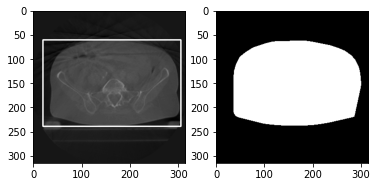

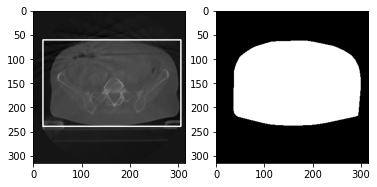

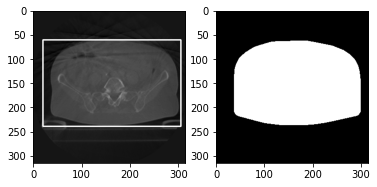

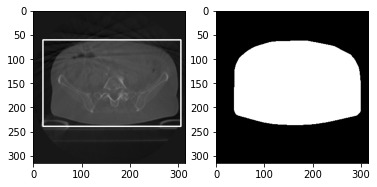

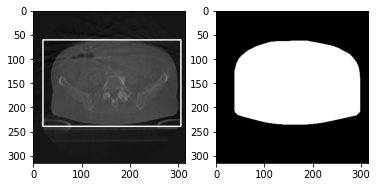

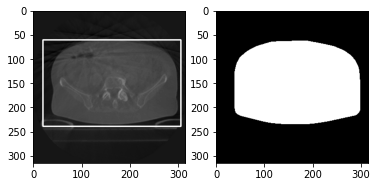

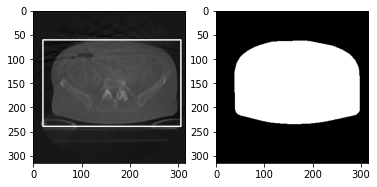

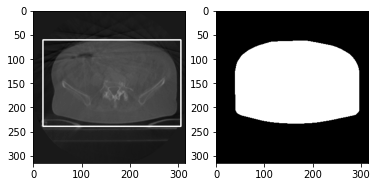

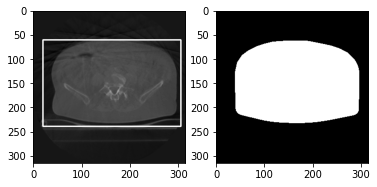

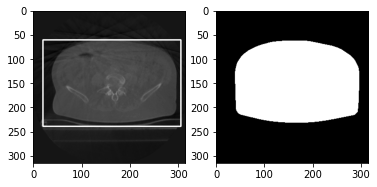

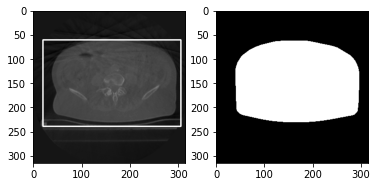

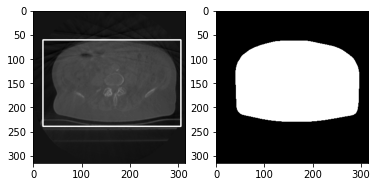

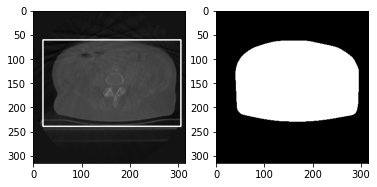

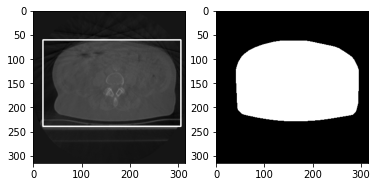

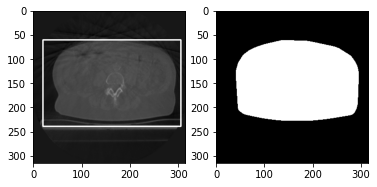

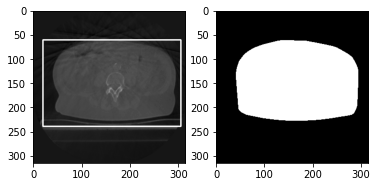

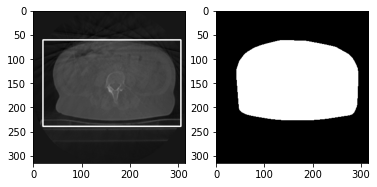

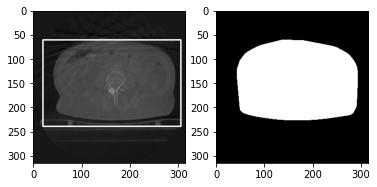

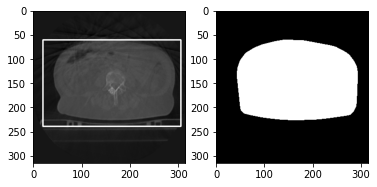

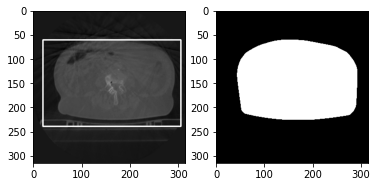

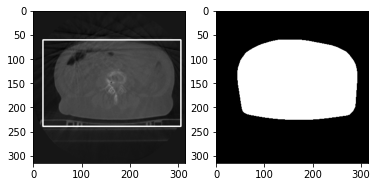

In [17]:
CBCT_array = sitk.GetArrayFromImage(CBCT)

mask, bound = body_mask_and_bound(CBCT_array)

show_mask_bound(CBCT_array, mask, bound)

Number of connected components found: 42


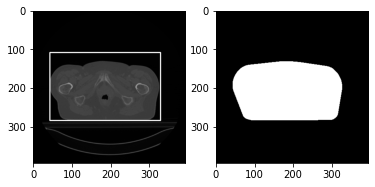

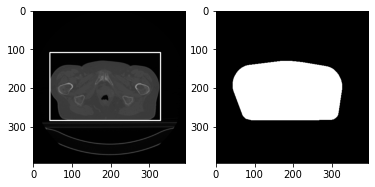

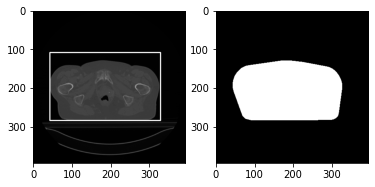

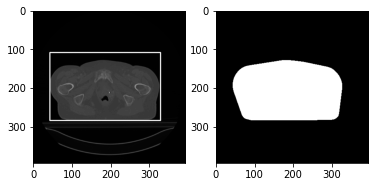

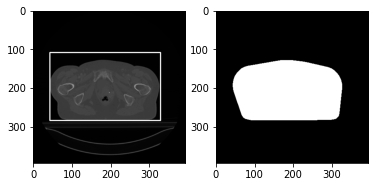

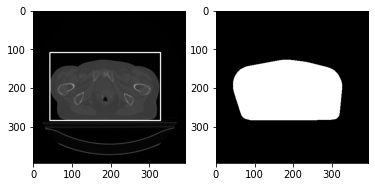

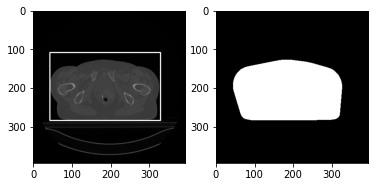

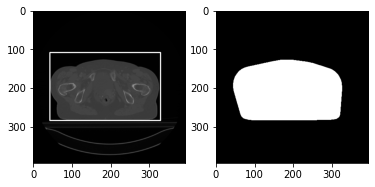

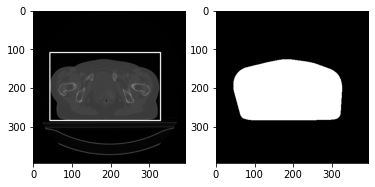

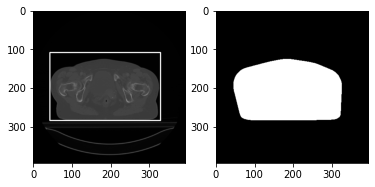

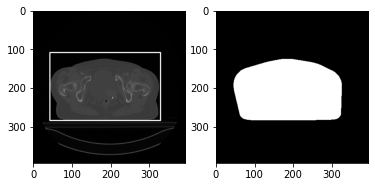

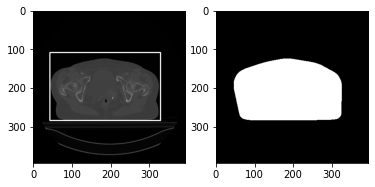

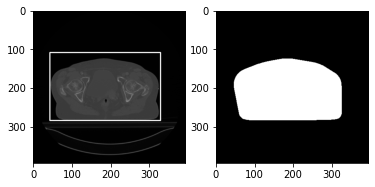

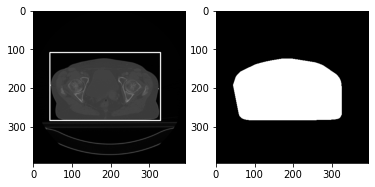

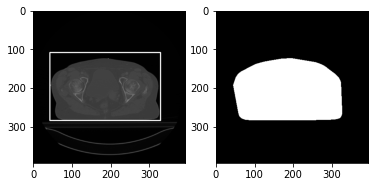

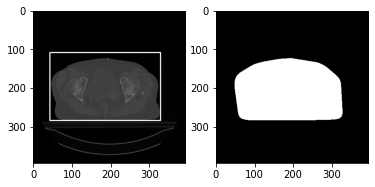

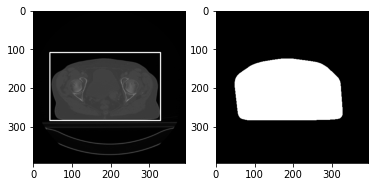

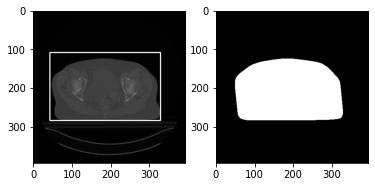

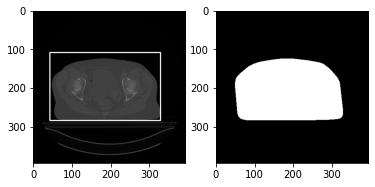

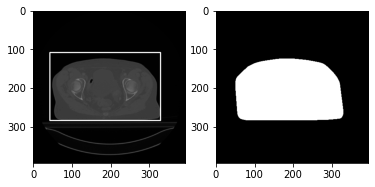

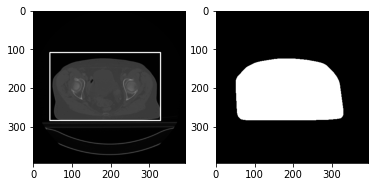

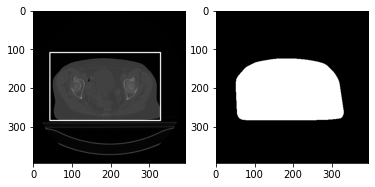

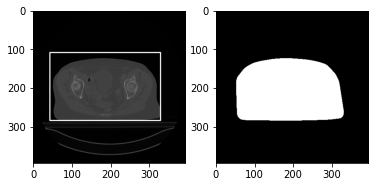

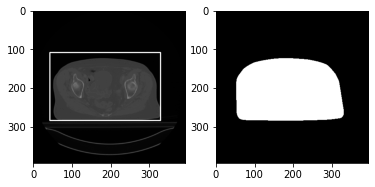

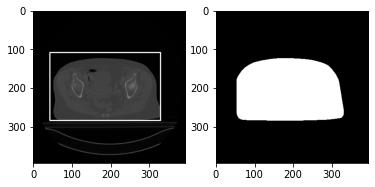

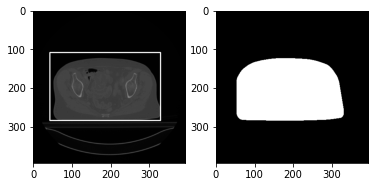

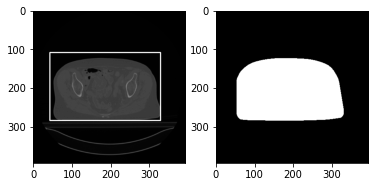

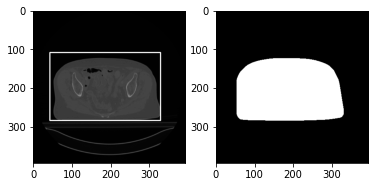

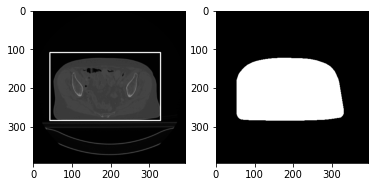

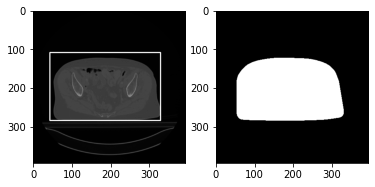

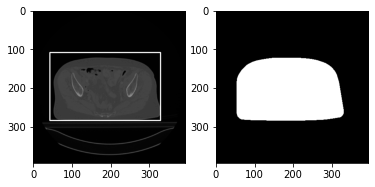

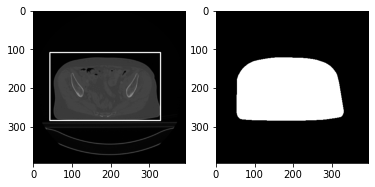

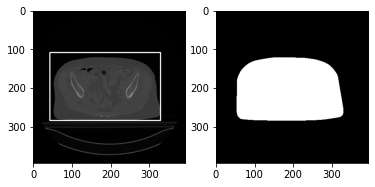

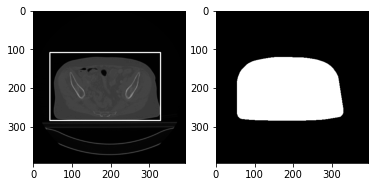

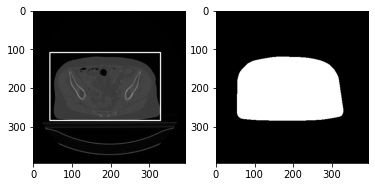

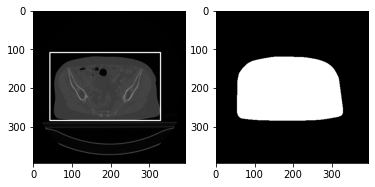

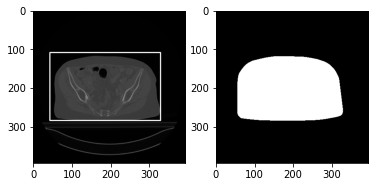

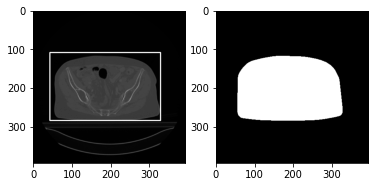

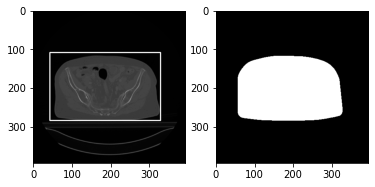

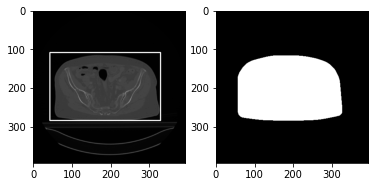

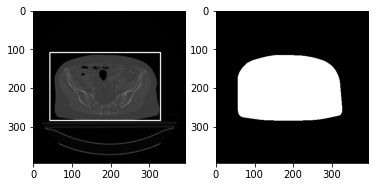

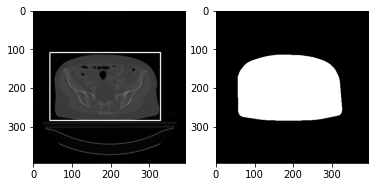

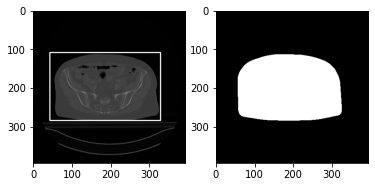

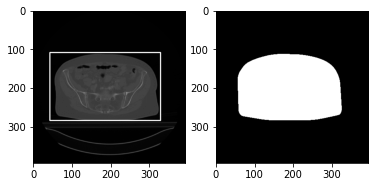

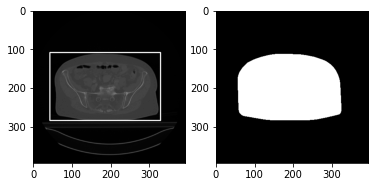

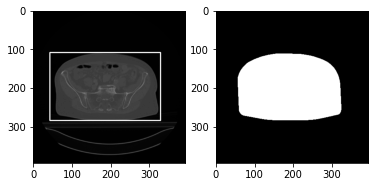

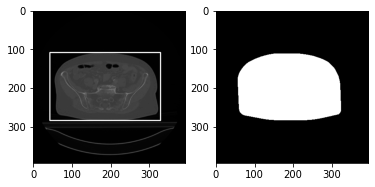

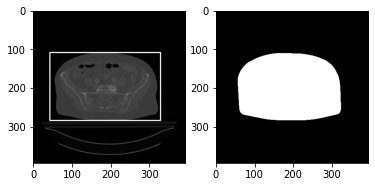

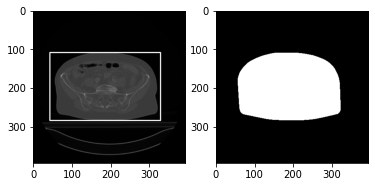

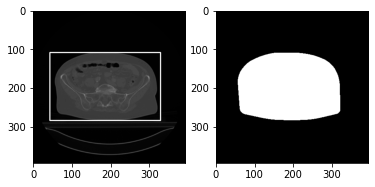

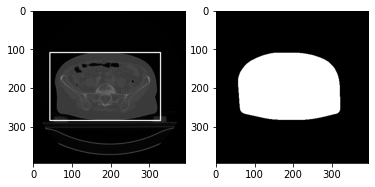

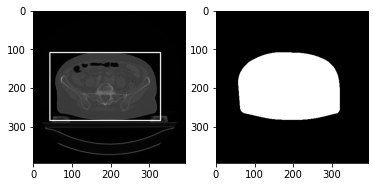

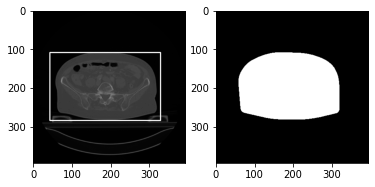

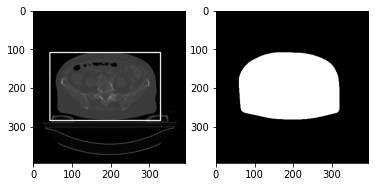

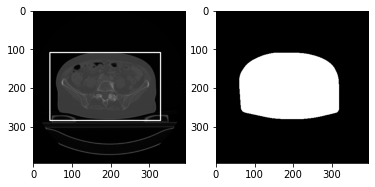

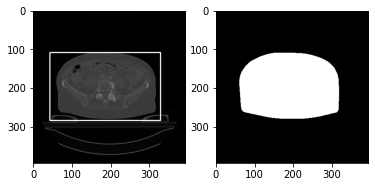

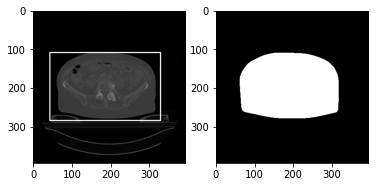

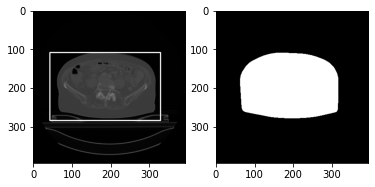

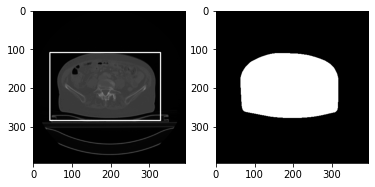

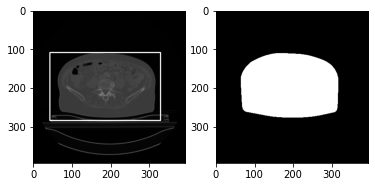

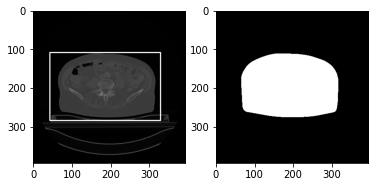

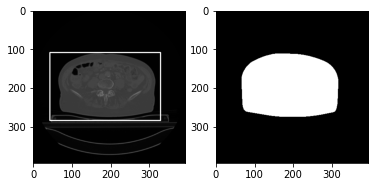

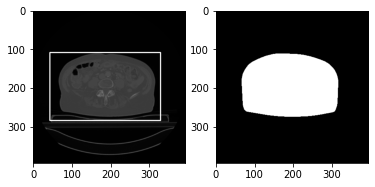

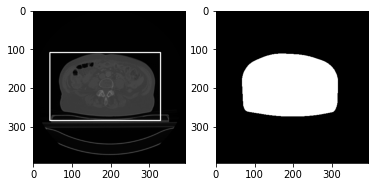

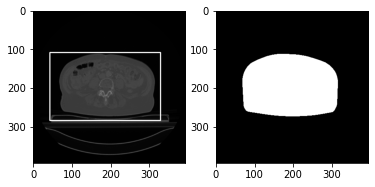

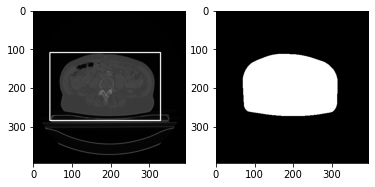

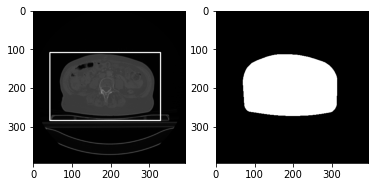

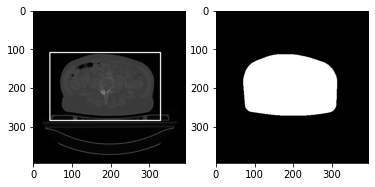

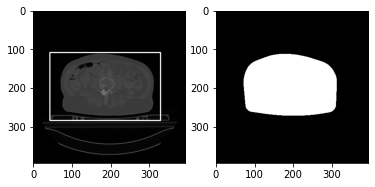

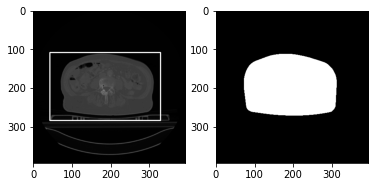

In [20]:
CT_array = sitk.GetArrayFromImage(CT_truncated)

mask, bound = body_mask_and_bound(CT_array)

show_mask_bound(CT_array, mask, bound)